In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Implement DeepSequence VAE model


In [ ]:
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta

--2022-01-08 10:48:51--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  13.9MB/s    in 0.2s    

2022-01-08 10:48:51 (13.9 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]



In [ ]:
# parsing the FASTA file, codes from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb
import os
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

# FASTA parser requires Biopython
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Retrieve protein alignment file
if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
        
# Retrieve file with experimental measurements
if not os.path.exists('BLAT_ECOLX_Ranganathan2015.csv'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
        
# Options
batch_size = 16

# Mapping from amino acids to integers
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22}
aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-"

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

def get_data(data_filename, calc_weights=False, weights_similarity_threshold=0.8):
    '''Create dataset from FASTA filename'''
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)       
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
        label = label_re.search(record.description).group(1)
        # Only use most common classes
        if label not in phyla:
            label = 'Other'
        labels.append(label)
                
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)
    
    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)

    dataset = torch.utils.data.TensorDataset(*[seqs, torch.from_numpy(phyla_idx)])
    
    
    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
            weights.append(w)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return dataset, weights


dataset, weights = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

     |████████████████████████████████| 2.3 MB 15.4 MB/s 
--2022-01-08 10:49:01--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  --.-KB/s    in 0.1s    

2022-01-08 10:49:01 (8.09 MB/s) - ‘BLAT_ECOLX_Ranganathan2015.csv’ saved [1216640/1216640]



## 1.1 Implement a standard VAE

In [ ]:
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [ ]:
class standard_VAE(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500) # 1500 is the number in the papar
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, 2000)
        self.fc23 = nn.Linear(2000, input_size)

        self.device = device
    
    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        z_mu = self.fc131(hidden)
        z_sd = torch.exp(self.fc132(hidden))

        return z_mu, z_sd

    def decoder(self, z):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.ReLU()(self.fc22(hidden))
        x = self.fc23(hidden)

        return x.reshape(z.shape[0], -1, 23)
    
    def forward(self, x, mc_samples=1):
        z_mu, z_sd = self.encoder(x)

        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        # since both prior and posterior are diag-Gaussian, the KL divergence between q(z|x) and p(z) is just the sum of the KL divergence in each dimension
        KL_post_prior = torch.sum(torch.distributions.kl.kl_divergence(posterior, prior), dim=-1)

        # E_q[p(x|z)] (sum because p(x|z) = p(x1|z)p(x2|z)...)
        z = torch.randn_like(z_mu) * z_sd + z_mu
        x_logit = self.decoder(z)
        Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        for sample in range(mc_samples-1):
            z = torch.randn_like(z_mu) * z_sd + z_mu
            x_logit = self.decoder(z)
            Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        Ep = Ep / mc_samples

        ELBO = torch.sum(Ep - KL_post_prior)

        return ELBO, z_mu, z_sd
    
    def forward_IWAE(self, x, mc_samples_l=1, mc_samples_k=10):
        z_mu, z_sd = self.encoder(x)
        
        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        LOG_Ps = []
        for s in range(mc_samples_l):
            log_p = []
            for sample in range(mc_samples_k):
                z = torch.randn_like(z_mu) * z_sd + z_mu
                x_logit = self.decoder(z)
                log_p.append(
                    torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1, keepdim=True) + \
                    torch.sum(prior.log_prob(z) - posterior.log_prob(z), dim=-1, keepdim=True))
            log_p = torch.cat(log_p, dim=-1)

            # To avoid numerical unstable
            log_p_max = torch.max(log_p, dim=-1, keepdim=True)[0]
            LOG_Ps.append(torch.log(torch.sum(torch.exp(log_p - log_p_max), dim=-1, keepdim=True) / mc_samples_k) + log_p_max)
        LOG_Ps = torch.sum(torch.cat(LOG_Ps, dim=-1), dim=-1) / mc_samples_l
        
        L_IWAE = torch.sum(LOG_Ps)

        return L_IWAE, z_mu, z_sd



## 1.2 Visualize the z-space

In [ ]:
def train(model, dl, optimizer, device):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model(i[0].to(device))
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
# train the model
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_dim_2 = standard_VAE(input_size, 2, device=DEVICE).to(DEVICE)

EPOCH = 180

ELBOs = [train(standard_vae_dim_2, dataloader, Adam(standard_vae_dim_2.parameters(), lr=0.001), DEVICE) for epoch in tqdm(range(EPOCH))]

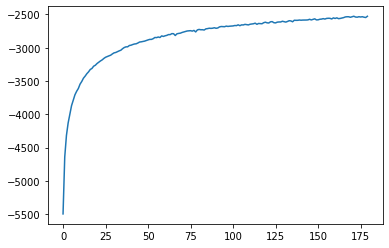

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_dim_2.pkl"
#torch.save(standard_vae_dim_2.state_dict(),PATH)
standard_vae_dim_2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = standard_vae_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()

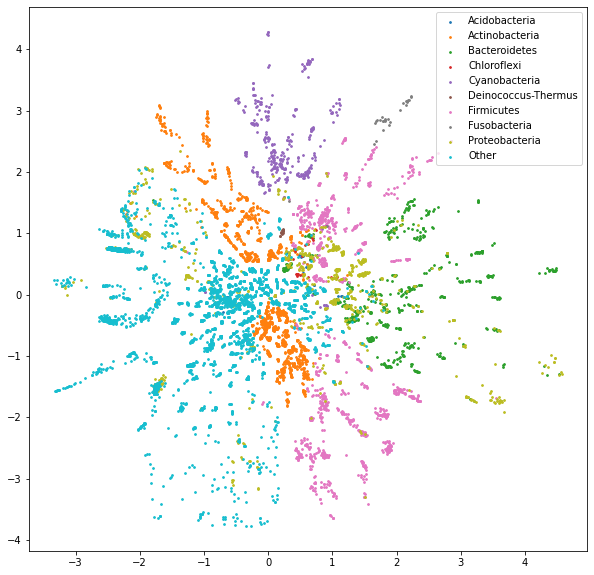

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()

In [ ]:
# raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
# z_mu, _ = standard_vae.encoder(raw_sequence)
# torch.argmax(standard_vae.decoder(z_mu), dim=-1) == raw_sequence

tensor([[False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [ ]:
# raw_sequence = dataset[100][0][np.newaxis, :].to(DEVICE)
# z_mu, _ = standard_vae_weighted.encoder(raw_sequence)
# torch.argmax(standard_vae_weighted.decoder(z_mu), dim=-1) == raw_sequence

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

## 1.3  Quantitative assessment

In [ ]:
# retrain the model with dim(z) = 30
# train the model
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

# EPOCH = 180
# ELBOs = []
# for epoch in tqdm(range(EPOCH)):
#     ELBOs.append(train(standard_vae, dataloader, Adam(standard_vae.parameters(), lr=1e-4), DEVICE))

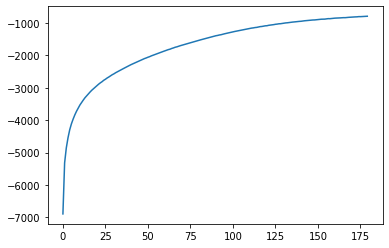

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae.pkl"
#torch.save(standard_vae.state_dict(),PATH)
standard_vae.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
! wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv

# Read in the experimental data, codes by Wooter from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb

def read_experimental_data(filename, alignment_data, measurement_col_name = '2500', sequence_offset=0):
    '''Read experimental data from csv file, and check that amino acid match those 
       in the first sequence of the alignment.
       
       measurement_col_name specifies which column in the csv file contains the experimental 
       observation. In our case, this is the one called 2500.
       
       sequence_offset is used in case there is an overall offset between the
       indices in the two files.
       '''
    
    measurement_df = pd.read_csv(filename, delimiter=',', usecols=['mutant', measurement_col_name])
    
    wt_sequence, wt_label = alignment_data[0]
    
    zero_index = None
    
    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = entry['mutant'][:1],int(entry['mutant'][1:-1]),entry['mutant'][-1:]  
        
        # Use index of first entry as offset (keep track of this in case 
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position
            
        # Corresponding position in our alignment
        seq_position = position-zero_index+sequence_offset
            
        # Make sure that two two inputs agree on the indices: the 
        # amino acids in the first entry of the alignment should be 
        # identical to those in the experimental file.
        assert mutant_from == aa1[wt_sequence[seq_position]]  
        
        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}
        
        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]
        
        experimental_data[seq_position]['pos'] = seq_position
        experimental_data[seq_position]['WT'] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]
    
    experimental_data = pd.DataFrame(experimental_data).transpose().set_index(['pos', 'WT'])
    return experimental_data
        
        
experimental_data = read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)
# For each of the entries in the dataframe above, you should calculate
# the corresponding difference in ELBO from your VAE, and then finally
# calculate a Spearman correlation between the two.

# # You can iterate over all experimental values like this:
# for (position, mutant_from), row in experimental_data.iterrows():
#     print(position, mutant_from)   # mutant from is the wild type (wt)
#     for mutant_to, exp_value in row.iteritems():
#         print("\t", mutant_to, exp_value) 

--2022-01-07 15:15:33--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv.2’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  6.57MB/s    in 0.2s    

2022-01-07 15:15:33 (6.57 MB/s) - ‘BLAT_ECOLX_Ranganathan2015.csv.2’ saved [1216640/1216640]



In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = standard_vae(raw_sequence, 50)
    for (position, mutant_from), row in experimental_data.iterrows():
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = standard_vae(new_sequence, 50)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.5031516430567009, pvalue=0.0)

## 1.4 Sequence reweighting

In [ ]:
dataset, weights = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))

In [ ]:
# retrain the model with dim(z) = 30
# train the model
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

# EPOCH = 180
# ELBOs = []
# for epoch in tqdm(range(EPOCH)):
#     ELBOs.append(train(standard_vae_weighted, dataloader_weighted, Adam(standard_vae_weighted.parameters(), lr=1e-4), DEVICE))

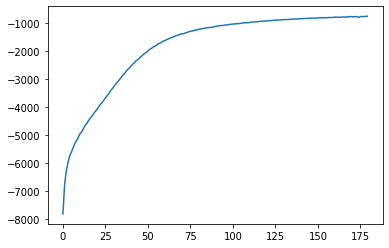

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_weighted.pkl"
#torch.save(standard_vae_weighted.state_dict(),PATH)
standard_vae_weighted.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = standard_vae_weighted(raw_sequence, 100)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = standard_vae_weighted(new_sequence, 100)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

263it [09:01,  2.06s/it]


In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.5508319465864908, pvalue=0.0)

In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = standard_vae_weighted.forward_IWAE(raw_sequence, 100, 10)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = standard_vae_weighted.forward_IWAE(new_sequence, 100, 10)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
spearmanr(experiment_value, predicted_value)

263it [2:16:34, 31.16s/it]


SpearmanrResult(correlation=0.5474712332302395, pvalue=0.0)

In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.5474712332302395, pvalue=0.0)

## 2.1, 2.2, 2.4 TODO


## 2.3 IWAE

In [ ]:
def train_IWAE(model, dl, optimizer, device):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model.forward_IWAE(i[0].to(device))
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted_IWAE = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 180
ELBOs = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train_IWAE(standard_vae_weighted_IWAE, dataloader_weighted, Adam(standard_vae_weighted_IWAE.parameters(), lr=1e-4), DEVICE))

100%|██████████| 180/180 [53:06<00:00, 17.70s/it]


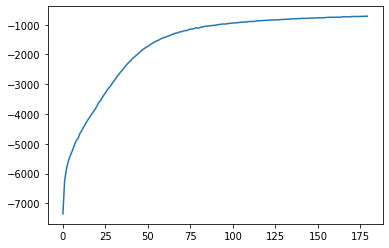

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_weighted_IWAE.pkl"
torch.save(standard_vae_weighted_IWAE.state_dict(),PATH)
# standard_vae_weighted_IWAE.load_state_dict(torch.load(PATH))

In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = standard_vae_weighted_IWAE.forward_IWAE(raw_sequence, 100, 5)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = standard_vae_weighted_IWAE.forward_IWAE(new_sequence, 100, 5)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

263it [1:09:55, 15.95s/it]


In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.5153426130782195, pvalue=0.0)

In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted_IWAE_dim_2 = standard_VAE(input_size, 2, device=DEVICE).to(DEVICE)

EPOCH = 200
ELBOs = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train_IWAE(standard_vae_weighted_IWAE_dim_2, dataloader_weighted, Adam(standard_vae_weighted_IWAE_dim_2.parameters(), lr=1e-3), DEVICE))

100%|██████████| 200/200 [58:51<00:00, 17.66s/it]


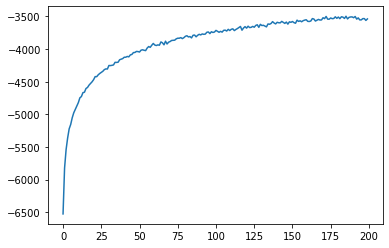

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_weighted_IWAE_dim_2.pkl"
torch.save(standard_vae_weighted_IWAE_dim_2.state_dict(),PATH)
# standard_vae_weighted_IWAE_dim_2.load_state_dict(torch.load(PATH))

In [ ]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = standard_vae_weighted_IWAE_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()

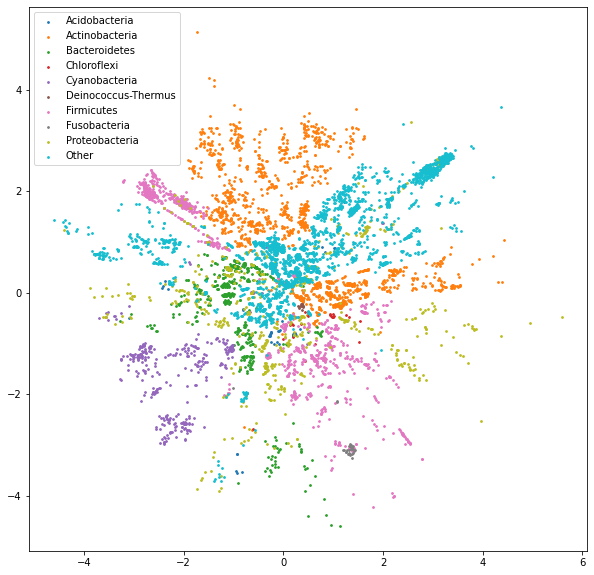

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()